In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import box
from matplotlib.colors import Normalize
from matplotlib import cm



import geopandas as gpd
from shapely.geometry import Point


ferp_path = '../data/ferp/geoforest/doi_10_5061_dryad_6q573n64s__v20240129/FERP123merged_20231029.csv'

# Load the dataset
df = pd.read_csv(ferp_path)

# Overview
print(df.shape)
print(df.columns)


# Create GeoDataFrame
df_geo = df.dropna(subset=["east_UTM", "north_UTM"]).copy()
gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["east_UTM"], df_geo["north_UTM"]),
    crs="EPSG:32610"  # UTM Zone 10N
)





# --- Load EnMAP image for RGB and metadata ---
enmap_path = "../data/ferp/enmap/ENMAP01-____L2A-DT0000007897_20230215T193730Z_021_V010303_20230823T164547Z-SPECTRAL_IMAGE_COG.tiff"
with rasterio.open(enmap_path) as src:
    r = src.read(44)
    g = src.read(29)
    b = src.read(9)
    transform = src.transform
    enmap_crs = src.crs
    width, height = src.width, src.height
    bounds = src.bounds

rgb = np.stack([r, g, b], axis=-1).astype(np.float32)
rgb /= np.nanmax(rgb)
vmin, vmax = np.percentile(rgb[~np.isnan(rgb)], [2, 98])
rgb_image_stretched = np.clip((rgb - vmin) / (vmax - vmin), 0, 1)

enmap_xmin = transform.c
enmap_xmax = transform.c + transform.a * width
enmap_ymax = transform.f
enmap_ymin = transform.f + transform.e * height

# --- Reproject FERP stems to EnMAP CRS ---
gdf_all = gdf.to_crs(enmap_crs)

# --- Create grid aligned with EnMAP pixels ---
pixel_width = transform.a
pixel_height = -transform.e
origin_x = transform.c
origin_y = transform.f

grid_cells = []
for row in range(height):
    for col in range(width):
        x0 = origin_x + col * pixel_width
        x1 = x0 + pixel_width
        y1 = origin_y - row * pixel_height
        y0 = y1 - pixel_height
        grid_cells.append(box(x0, y0, x1, y1))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=enmap_crs)

# --- Spatial join: all stems to pixel grid ---
joined = gpd.sjoin(gdf_all, grid, how="left", predicate="within")
joined = joined.dropna(subset=["index_right"])

# Group by pixel index and species code
species_counts = (
    joined.groupby(["index_right", "code6"])
    .size()
    .unstack(fill_value=0)
)

# Join back to grid GeoDataFrame
grid = grid.join(species_counts, how="left")
grid = grid.fillna(0)



import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box


# Drop NA quadrats
df_q = df.dropna(subset=["quadrat"])

# Parse quadrat into numeric east/north
def parse_quadrat(q):
    parts = q.replace("E", "").split("_N")
    return int(parts[0]), int(parts[1])

df_q["east_quadrat"], df_q["north_quadrat"] = zip(*df_q["quadrat"].map(parse_quadrat))

# Remove duplicates to get unique subplots
unique_quads = df_q[["east_quadrat", "north_quadrat"]].drop_duplicates()

# Build quadrat polygons
quad_gdf = gpd.GeoDataFrame(
    unique_quads,
    geometry=[
        box(e, n, e + 20, n + 20)
        for e, n in zip(unique_quads["east_quadrat"], unique_quads["north_quadrat"])
    ],
    crs="EPSG:32610"  # Assuming UTM coordinates
)

# Combine all quadrats into a single polygon and reproject to match EnMAP CRS
ferp_boundary = gpd.GeoDataFrame(
    geometry=[quad_gdf.unary_union.convex_hull],  # use .unary_union.buffer(0) for exact shape if needed
    crs=quad_gdf.crs
)


# Build quadrat polygons from parsed E/N UTM directly
quad_gdf = gpd.GeoDataFrame(
    unique_quads,
    geometry=[
        box(e, n, e + 20, n + 20)
        for e, n in zip(unique_quads["east_quadrat"], unique_quads["north_quadrat"])
    ],
    crs="EPSG:32610"
)

# Build rotated FERP boundary from stem points (in EPSG:32610)
ferp_boundary_utm = gpd.GeoDataFrame(
    geometry=[gdf_all.unary_union.minimum_rotated_rectangle],
    crs=gdf_all.crs
)

# Reproject to match grid/EnMAP CRS
ferp_boundary_enmap = ferp_boundary_utm.to_crs(grid.crs)




with rasterio.open(enmap_path) as src:
    image = src.read()  # shape: (bands, height, width)
    transform = src.transform
    enmap_crs = src.crs
    height, width = src.height, src.width


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/183703450.py:18: DtypeWarning: Columns (13,16,17,23,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ferp_path)


(51016, 34)
Index(['quadrat', 'tag', 'stemtag', 'stemtag1', 'code6', 'east_m', 'north_m',
       'east_UTM', 'north_UTM', 'dsh1_mm', 'dsh2_mm', 'dsh3_mm', 'dsh1m_mm',
       'date1', 'date2', 'date3', 'status1', 'condition1', 'status2',
       'condition2', 'status3', 'condition3', 'first_census', 'irreg_dsh',
       'hom_m', 'multi1', 'stems1', 'multi2', 'multi3', 'basalarea1_m2',
       'code6fix', 'locfix', 'notes2', 'notes3'],
      dtype='object')


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/183703450.py:126: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry=[quad_gdf.unary_union.convex_hull],  # use .unary_union.buffer(0) for exact shape if needed
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/183703450.py:143: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry=[gdf_all.unary_union.minimum_rotated_rectangle],


In [42]:
# Filter EnMAP pixel grid to those fully within the FERP boundary
grid = grid[grid.geometry.within(ferp_boundary_enmap.geometry.iloc[0])]


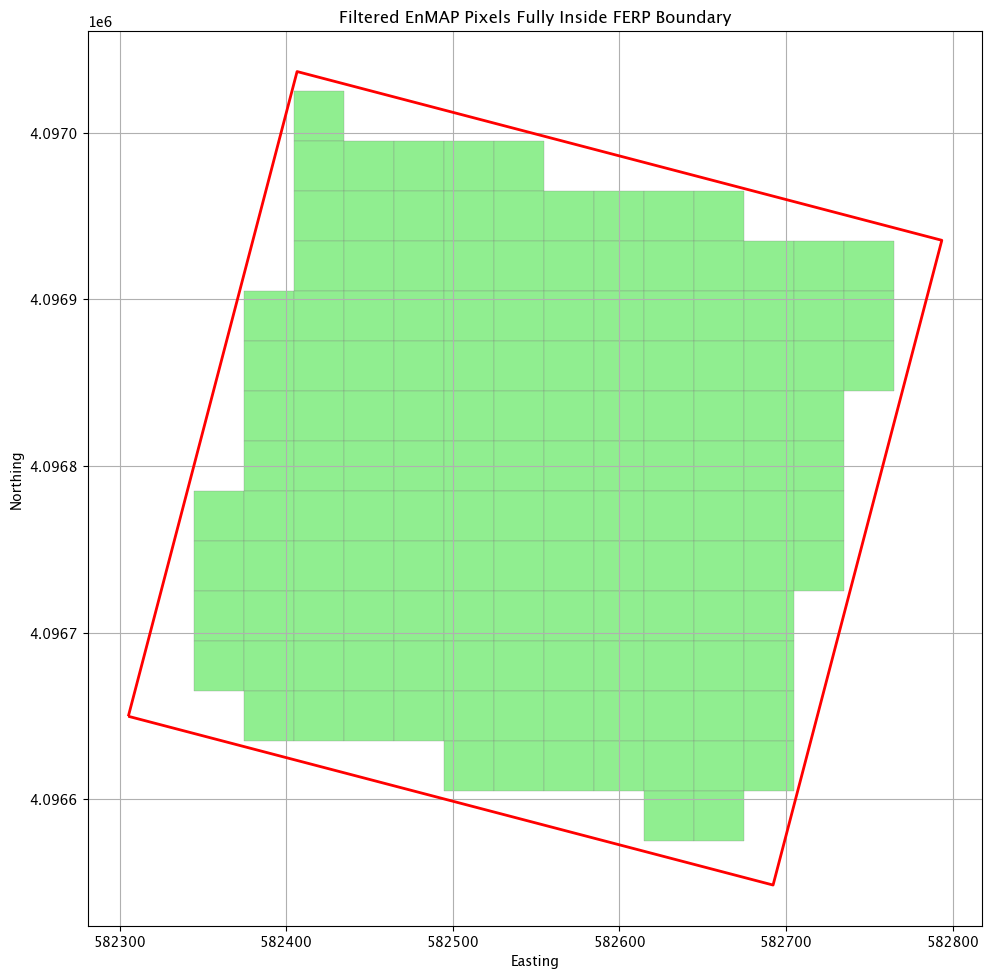

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
grid.plot(ax=ax, facecolor="lightgreen", edgecolor="gray", linewidth=0.2)
ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2)
ax.set_title("Filtered EnMAP Pixels Fully Inside FERP Boundary")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
len(grid)

147

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# --- Select target species code ---
species_code = "SEQUSE"

# --- Get centroid coordinates of filtered EnMAP pixels ---
centroids = grid.geometry.centroid
xs, ys = centroids.x.values, centroids.y.values

# --- Convert to EnMAP image row/col indices ---
rows, cols = rasterio.transform.rowcol(transform, xs, ys)
rows = np.clip(rows, 0, image.shape[1] - 1)
cols = np.clip(cols, 0, image.shape[2] - 1)

# --- Extract hyperspectral feature vectors (1 row per pixel, all bands) ---
n_bands = image.shape[0]
X = np.stack([image[band, rows, cols] for band in range(n_bands)], axis=1)

# --- Binary target variable: presence/absence of species in each pixel ---
y = (grid[species_code] > 0).astype(int).values

# --- Remove pixels with NaN values ---
valid_mask = np.isfinite(X).all(axis=1)
X = X[valid_mask]
y = y[valid_mask]


In [45]:
# --- Split into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Train a Random Forest classifier ---
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [47]:


# --- Predict and evaluate ---
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print(f"📊 Classification Report for {species_code}:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))


📊 Classification Report for SEQUSE:
              precision    recall  f1-score   support

           0       0.67      0.83      0.74        12
           1       0.87      0.72      0.79        18

    accuracy                           0.77        30
   macro avg       0.77      0.78      0.76        30
weighted avg       0.79      0.77      0.77        30

ROC AUC Score: 0.8518518518518517


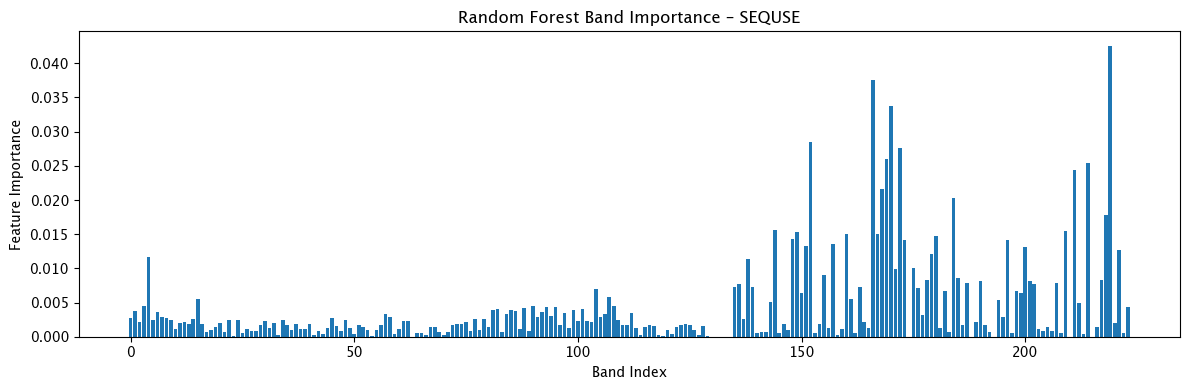

In [48]:


# --- Feature importance plot (optional) ---
plt.figure(figsize=(12, 4))
plt.bar(range(n_bands), clf.feature_importances_)
plt.xlabel("Band Index")
plt.ylabel("Feature Importance")
plt.title(f"Random Forest Band Importance – {species_code}")
plt.tight_layout()
plt.show()


In [50]:
# Predict presence probabilities and binary labels for all valid pixels
X_all = X  # already filtered to pixels inside FERP
y_true = y  # ground truth
y_pred = clf.predict(X_all)


# Keep only rows used in model (valid_mask from earlier)
grid_valid = grid[valid_mask].copy()
grid_valid["y_true"] = y_true
grid_valid["y_pred"] = y_pred




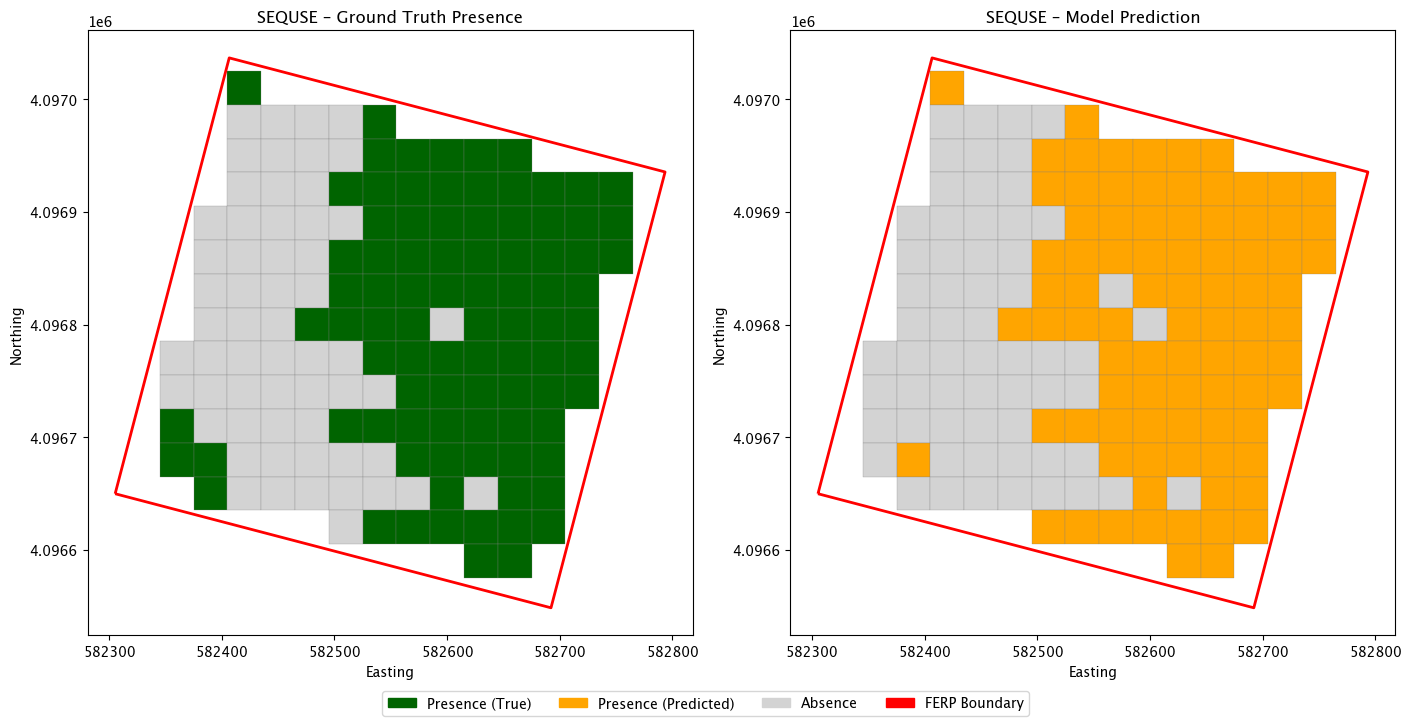

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Color maps
cmap_truth = {0: "lightgray", 1: "darkgreen"}
cmap_pred  = {0: "lightgray", 1: "orange"}

fig, axs = plt.subplots(1, 2, figsize=(14, 7), constrained_layout=True)

# --- Ground Truth ---
grid_valid.plot(
    ax=axs[0],
    color=grid_valid["y_true"].map(cmap_truth),
    edgecolor="gray",
    linewidth=0.2
)
ferp_boundary_enmap.boundary.plot(ax=axs[0], color="red", linewidth=2)
axs[0].set_title(f"{species_code} – Ground Truth Presence")
axs[0].set_xlabel("Easting")
axs[0].set_ylabel("Northing")

# --- Model Predictions ---
grid_valid.plot(
    ax=axs[1],
    color=grid_valid["y_pred"].map(cmap_pred),
    edgecolor="gray",
    linewidth=0.2
)
ferp_boundary_enmap.boundary.plot(ax=axs[1], color="red", linewidth=2)
axs[1].set_title(f"{species_code} – Model Prediction")
axs[1].set_xlabel("Easting")
axs[1].set_ylabel("Northing")

# Legends
legend_patches = [
    mpatches.Patch(color="darkgreen", label="Presence (True)"),
    mpatches.Patch(color="orange", label="Presence (Predicted)"),
    mpatches.Patch(color="lightgray", label="Absence"),
    mpatches.Patch(color="red", label="FERP Boundary")
]
fig.legend(handles=legend_patches, loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.05))
plt.show()


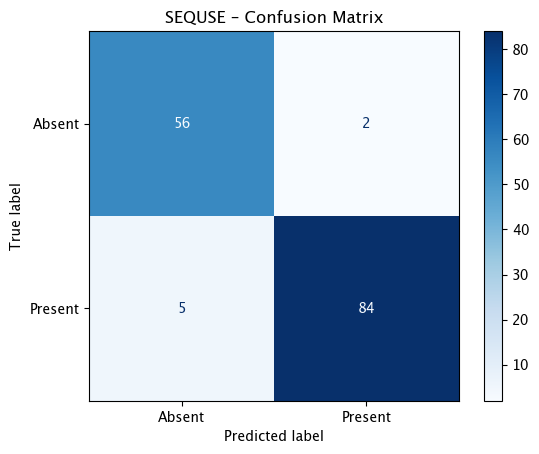

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Absent", "Present"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"{species_code} – Confusion Matrix")
plt.show()


In [53]:
# Get predicted probabilities for class 1 (presence)
y_prob = clf.predict_proba(X_all)[:, 1]
grid_valid["y_prob"] = y_prob


In [56]:
# Zoom to FERP boundary + buffer
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50  # meters
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)


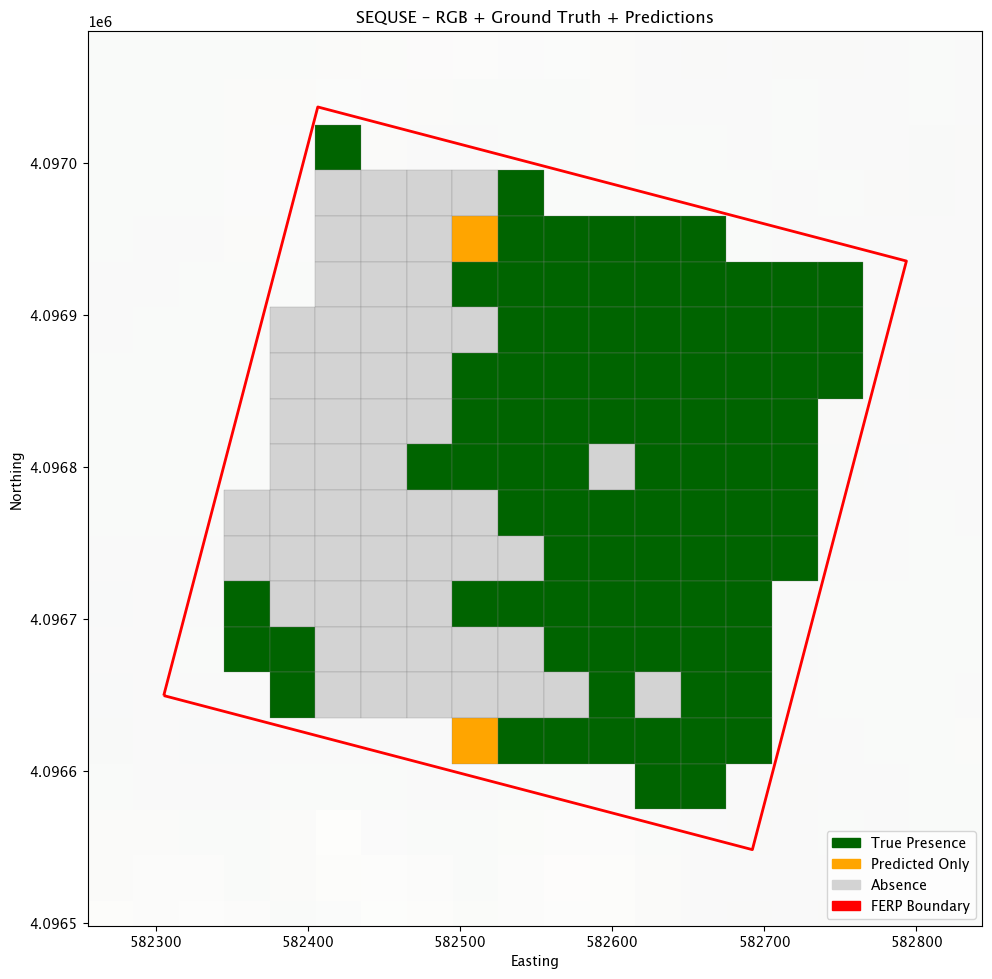

In [57]:
fig, ax = plt.subplots(figsize=(10, 10))

# RGB background
ax.imshow(rgb_image_stretched, extent=extent, origin="upper", zorder=1)

# Predicted/true presence
for _, row in grid_valid.iterrows():
    color = "lightgray"
    if row["y_true"] == 1:
        color = "darkgreen"
    if row["y_pred"] == 1 and row["y_true"] == 0:
        color = "orange"
    ax.add_patch(plt.Rectangle(
        (row.geometry.bounds[0], row.geometry.bounds[1]),
        row.geometry.bounds[2] - row.geometry.bounds[0],
        row.geometry.bounds[3] - row.geometry.bounds[1],
        facecolor=color,
        edgecolor="gray",
        linewidth=0.2,
        zorder=2
    ))

# Boundary
ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=3)

# Zoom
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# Labels
ax.set_title(f"{species_code} – RGB + Ground Truth + Predictions")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")

# Legend
legend_patches = [
    mpatches.Patch(color="darkgreen", label="True Presence"),
    mpatches.Patch(color="orange", label="Predicted Only"),
    mpatches.Patch(color="lightgray", label="Absence"),
    mpatches.Patch(color="red", label="FERP Boundary")
]
ax.legend(handles=legend_patches, loc="lower right")
plt.tight_layout()
plt.show()


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/1501686442.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("YlOrRd")


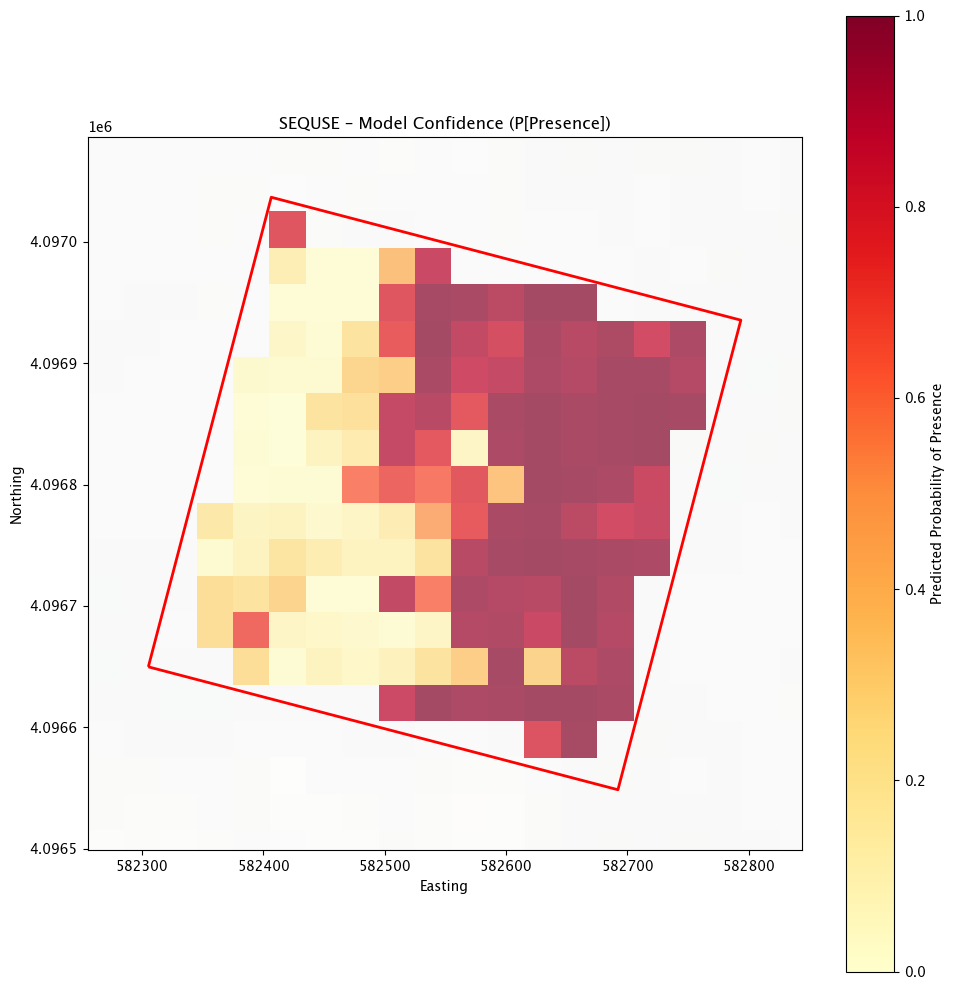

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))

# RGB background
ax.imshow(rgb_image_stretched, extent=extent, origin="upper", zorder=1)

# Heatmap overlay
norm = Normalize(vmin=0, vmax=1)
cmap = get_cmap("YlOrRd")
grid_valid.plot(
    ax=ax,
    column="y_prob",
    cmap=cmap,
    norm=norm,
    edgecolor="none",
    linewidth=0,
    alpha=0.7,
    zorder=2
)

# Boundary
ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=3)

# Zoom
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# Labels
ax.set_title(f"{species_code} – Model Confidence (P[Presence])")
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm._A = []
fig.colorbar(sm, ax=ax, label="Predicted Probability of Presence")

plt.tight_layout()
plt.show()


In [64]:
# From rasterio
with rasterio.open(enmap_path) as src:
    r = src.read(44)
    g = src.read(28)
    b = src.read(9)
    transform = src.transform
    width = src.width
    height = src.height

# Stack and normalize
rgb = np.stack([r, g, b], axis=-1).astype(np.float32)
vmin, vmax = np.percentile(rgb[rgb > -32768], [2, 98])
rgb_image_stretched = np.clip((rgb - vmin) / (vmax - vmin), 0, 1)

enmap_xmin = transform.c
enmap_xmax = transform.c + transform.a * width
enmap_ymax = transform.f
enmap_ymin = transform.f + transform.e * height

extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

rgb_plot = np.transpose(rgb_image_stretched, (1, 0, 2))  # (width, height, bands) → (height, width, bands)



In [65]:
# --- Stretch RGB for display
def stretch_rgb(rgb):
    vmin, vmax = np.percentile(rgb[rgb > -32768], [2, 98])
    return np.clip((rgb - vmin) / (vmax - vmin), 0, 1)

rgb_image = image[[44, 28, 9], :, :]
rgb_stretched = stretch_rgb(rgb_image)
rgb_plot = np.transpose(rgb_stretched, (1, 2, 0))  # H x W x 3

# --- Load and stretch RGB EnMAP image (already working)
rgb_image = image[[44, 28, 9], :, :]
rgb_stretched = stretch_rgb(rgb_image)
rgb_plot = np.transpose(rgb_stretched, (1, 2, 0))  # H x W x 3

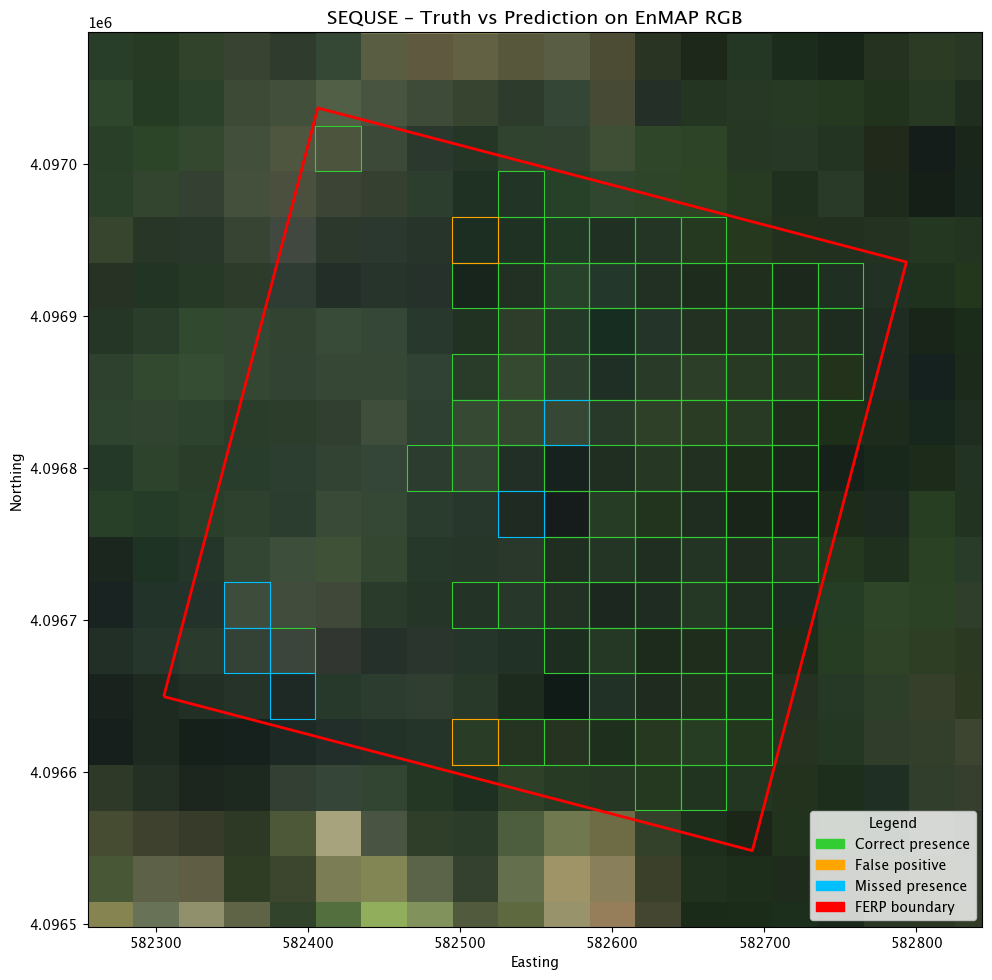

In [66]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# --- Compute EnMAP extent for imshow ---
extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

# --- Prep presence flags for plotting ---
grid_valid["presence_truth"] = (grid_valid["y_true"] == 1)
grid_valid["presence_pred"] = (grid_valid["y_pred"] == 1)

# --- Subsets for overlay
truth_only = grid_valid[(grid_valid["presence_truth"]) & (~grid_valid["presence_pred"])]
pred_only = grid_valid[(~grid_valid["presence_truth"]) & (grid_valid["presence_pred"])]
agree_both = grid_valid[(grid_valid["presence_truth"]) & (grid_valid["presence_pred"])]

# --- Zoom extents from FERP boundary ---
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 10))

# RGB background
ax.imshow(rgb_plot, extent=extent, origin="upper", zorder=1)

# Overlay: green = true + pred match, orange = pred only, blue = truth only
agree_both.boundary.plot(ax=ax, color="limegreen", linewidth=0.8, zorder=2, label="Correct prediction")
pred_only.boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3, label="False positive")
truth_only.boundary.plot(ax=ax, color="deepskyblue", linewidth=0.8, zorder=4, label="Missed presence")

# FERP boundary
ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=5)

# Zoom
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

# Labels and legend
ax.set_title(f"{species_code} – Truth vs Prediction on EnMAP RGB", fontsize=14)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")

legend_patches = [
    mpatches.Patch(color="limegreen", label="Correct presence"),
    mpatches.Patch(color="orange", label="False positive"),
    mpatches.Patch(color="deepskyblue", label="Missed presence"),
    mpatches.Patch(color="red", label="FERP boundary")
]
ax.legend(handles=legend_patches, title="Legend", loc="lower right")

plt.tight_layout()
plt.show()


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/934660221.py:60: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_valid[grid_valid["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/934660221.py:61: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_valid[grid_valid["fn"]].boundary.plot(ax=ax, color="deepskyblue", linewidth=0.8, zorder=4)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/934660221.py:60: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_valid[grid_valid["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/934660221.py:61: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_valid[grid_va

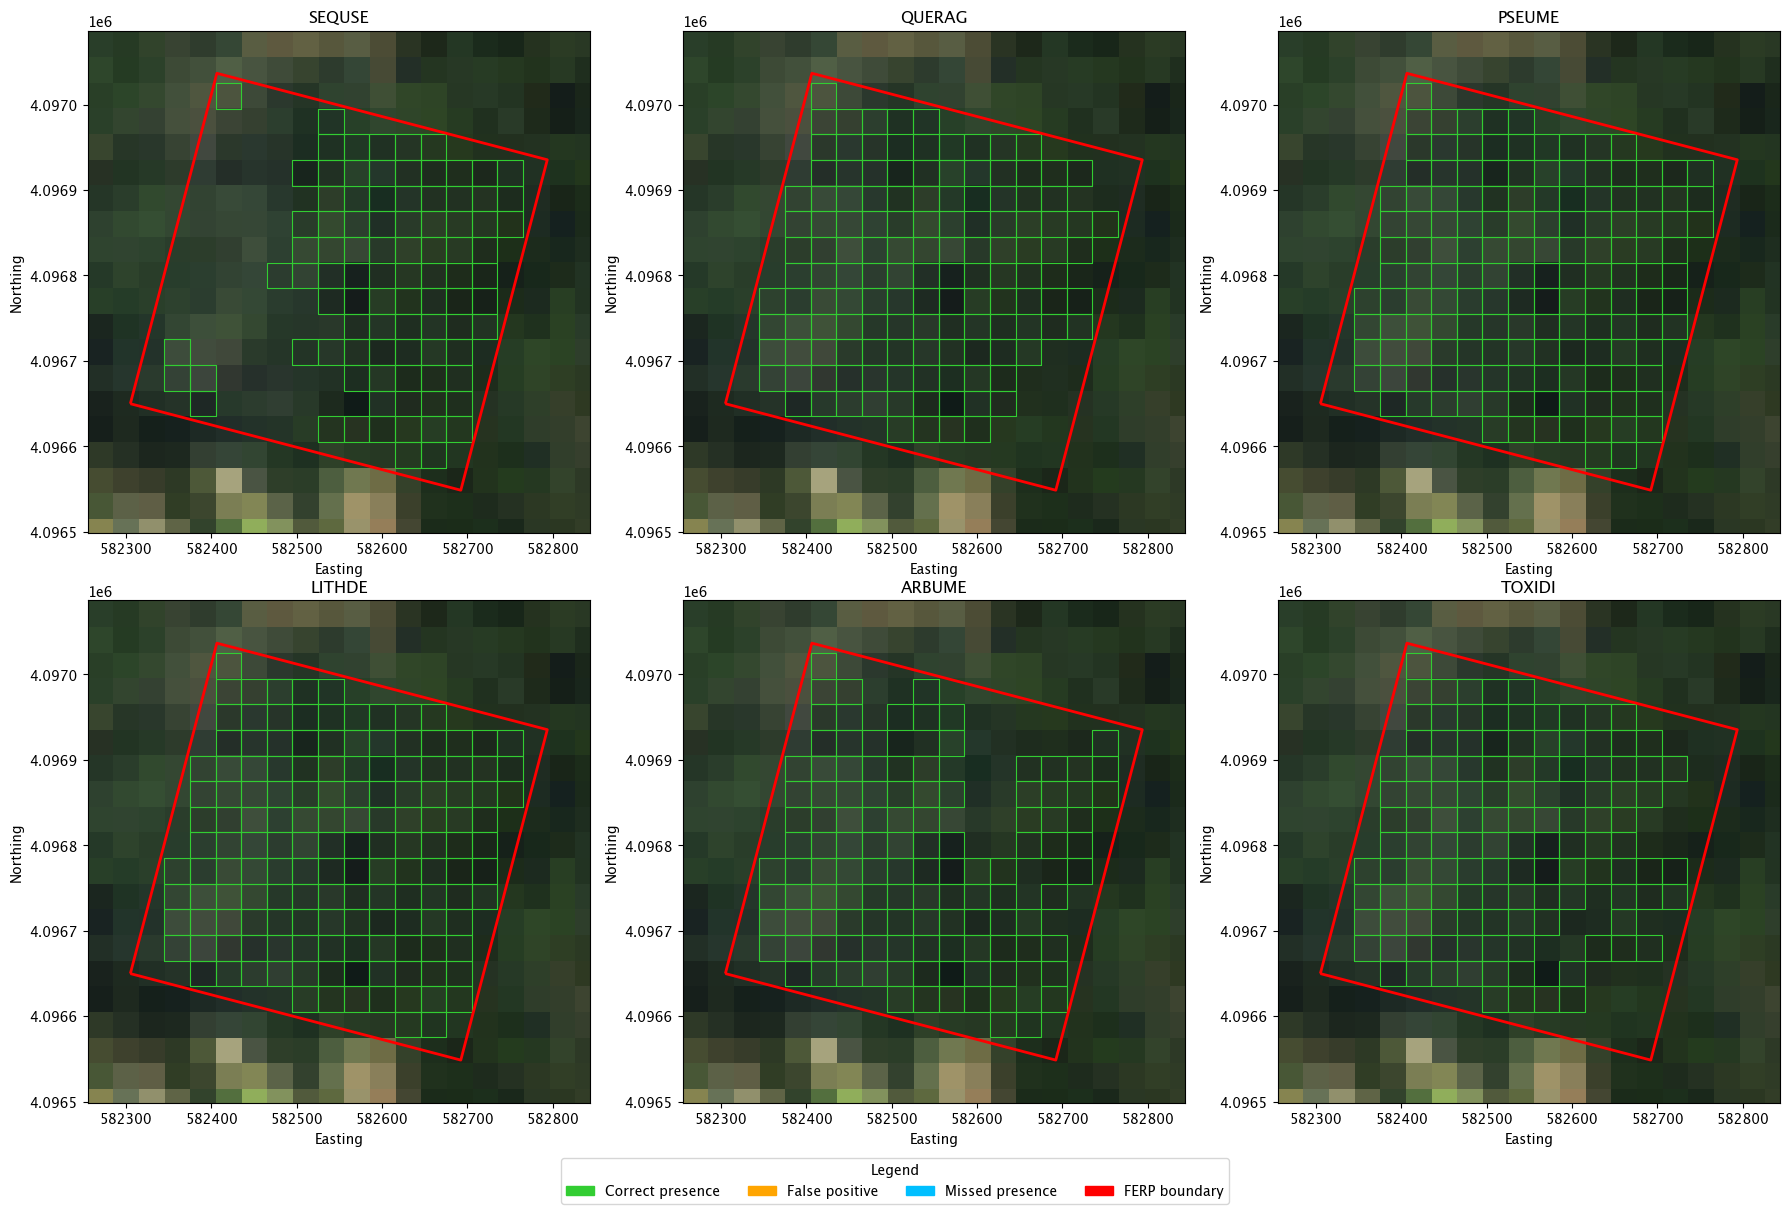

In [69]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize

# --- List of dominant species to plot ---
species_list = ["SEQUSE", "QUERAG", "PSEUME", "LITHDE", "ARBUME", "TOXIDI"]  # or dom_code_l
n_species = len(species_list)

# --- Zoom bounds from FERP boundary ---
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)
extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

# --- Create subplot grid ---
ncols = 3
nrows = int(np.ceil(n_species / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
axes = axes.flatten()

for i, species_code in enumerate(species_list):
    ax = axes[i]

    # --- Target variable ---
    grid["y_true"] = (grid[species_code] > 0).astype(int)
    y_true = grid["y_true"].values

    # --- Extract EnMAP pixel values for valid pixels ---
    centroids = grid.geometry.centroid
    xs, ys = centroids.x.values, centroids.y.values
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    rows = np.clip(rows, 0, image.shape[1] - 1)
    cols = np.clip(cols, 0, image.shape[2] - 1)
    X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

    # --- Drop any rows with NaNs ---
    valid_mask = np.isfinite(X).all(axis=1)
    X = X[valid_mask]
    y_true = y_true[valid_mask]
    grid_valid = grid[valid_mask].copy()

    # --- Train classifier and predict ---
    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
    clf.fit(X, y_true)
    y_pred = clf.predict(X)

    # --- Store in grid ---
    grid_valid["y_true"] = y_true
    grid_valid["y_pred"] = y_pred
    grid_valid["tp"] = (grid_valid["y_true"] == 1) & (grid_valid["y_pred"] == 1)
    grid_valid["fp"] = (grid_valid["y_true"] == 0) & (grid_valid["y_pred"] == 1)
    grid_valid["fn"] = (grid_valid["y_true"] == 1) & (grid_valid["y_pred"] == 0)

    # --- Background RGB image ---
    ax.imshow(rgb_plot, extent=extent, origin="upper", zorder=1)

    # --- Overlays ---
    grid_valid[grid_valid["tp"]].boundary.plot(ax=ax, color="limegreen", linewidth=0.8, zorder=2)
    grid_valid[grid_valid["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
    grid_valid[grid_valid["fn"]].boundary.plot(ax=ax, color="deepskyblue", linewidth=0.8, zorder=4)

    # --- FERP boundary ---
    ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=5)

    # --- Format subplot ---
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"{species_code}", fontsize=12)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")

# --- Shared legend ---
legend_patches = [
    mpatches.Patch(color="limegreen", label="Correct presence"),
    mpatches.Patch(color="orange", label="False positive"),
    mpatches.Patch(color="deepskyblue", label="Missed presence"),
    mpatches.Patch(color="red", label="FERP boundary")
]
fig.legend(handles=legend_patches, title="Legend", loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/3450096297.py:66: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_test[grid_test["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/3450096297.py:67: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_test[grid_test["fn"]].boundary.plot(ax=ax, color="deepskyblue", linewidth=0.8, zorder=4)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/3450096297.py:66: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_test[grid_test["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/3450096297.py:67: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  grid_test[grid_test[

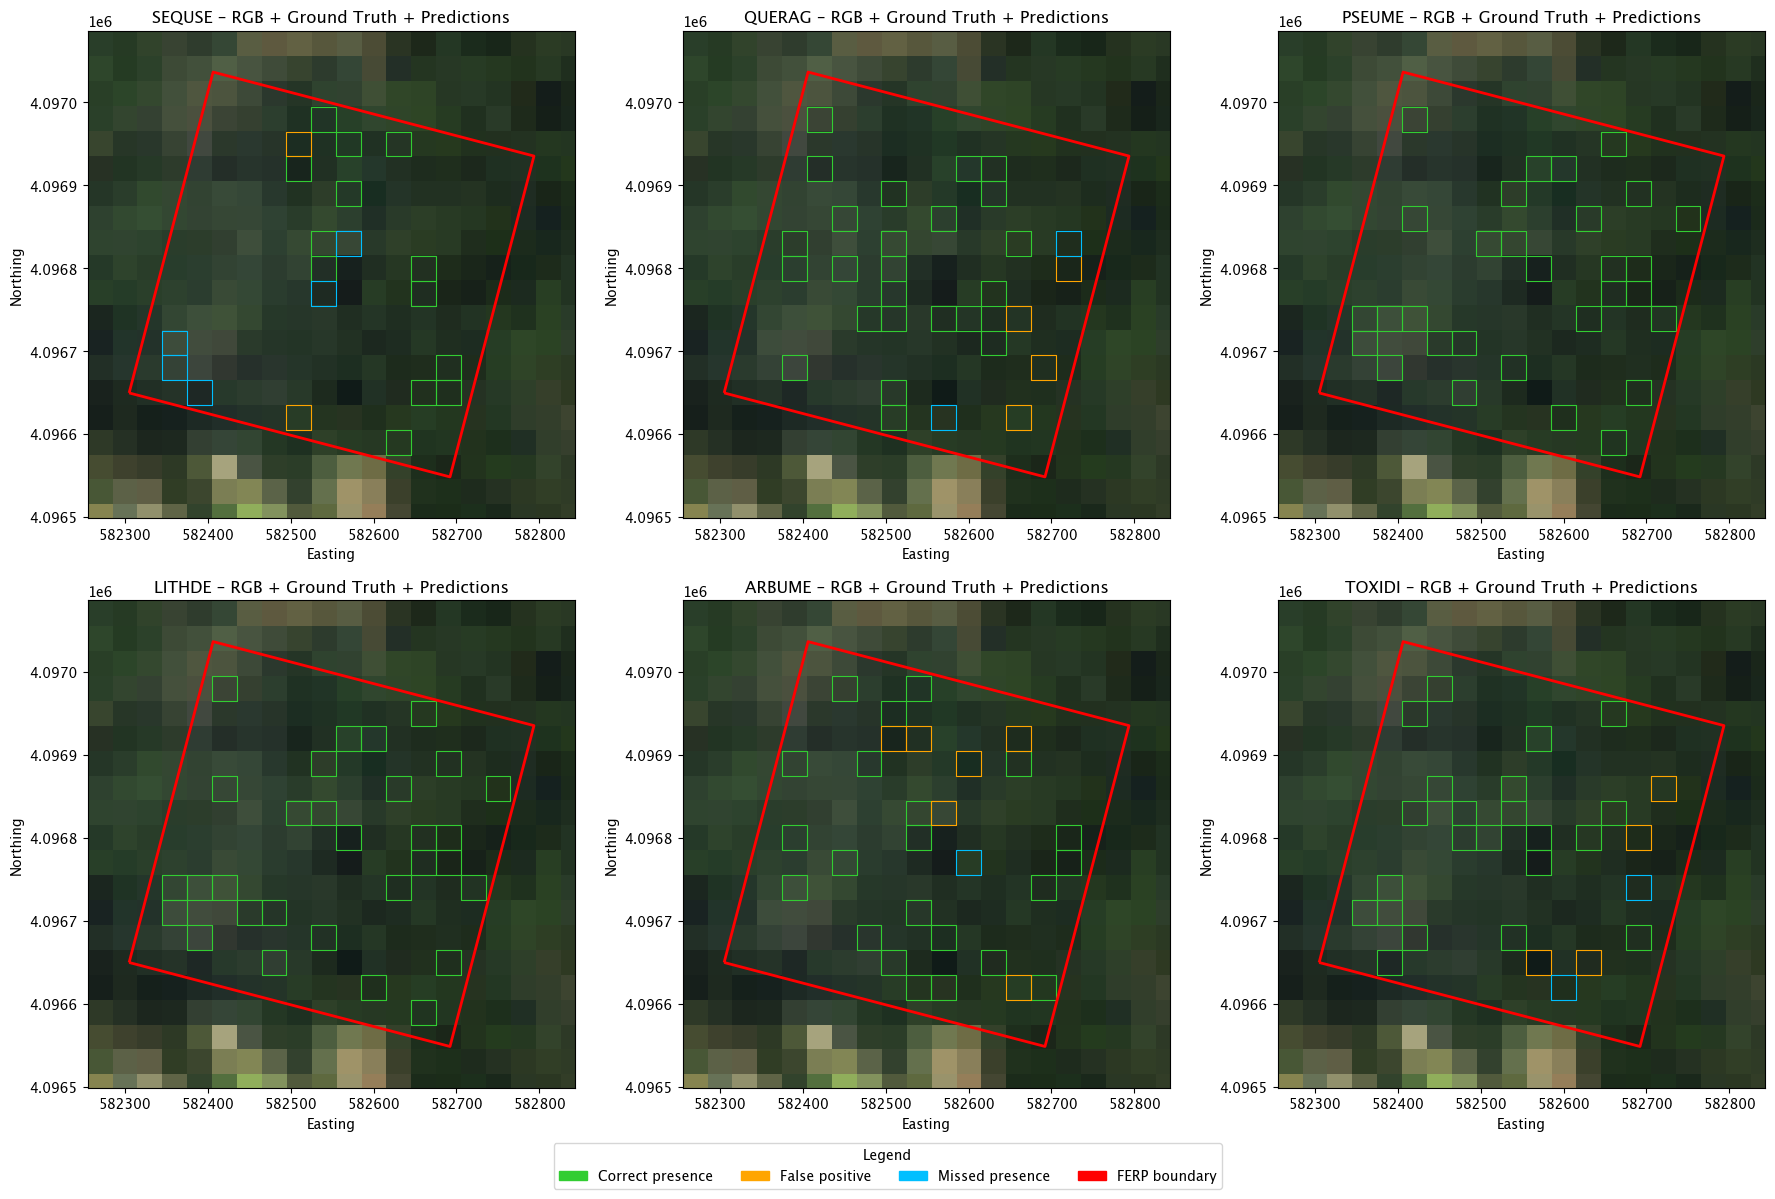

In [70]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# --- List of species ---
species_list = ["SEQUSE", "QUERAG", "PSEUME", "LITHDE", "ARBUME", "TOXIDI"]
ncols = 3
nrows = int(np.ceil(len(species_list) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
axes = axes.flatten()

# --- Zoom extents from FERP boundary ---
xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)
extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

for i, species_code in enumerate(species_list):
    ax = axes[i]

    # Prepare labels
    grid["y_true"] = (grid[species_code] > 0).astype(int)
    y = grid["y_true"].values

    # Get hyperspectral data per pixel
    centroids = grid.geometry.centroid
    xs, ys = centroids.x.values, centroids.y.values
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    rows = np.clip(rows, 0, image.shape[1] - 1)
    cols = np.clip(cols, 0, image.shape[2] - 1)
    X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

    # Drop NaNs
    valid_mask = np.isfinite(X).all(axis=1)
    X = X[valid_mask]
    y = y[valid_mask]
    grid_valid = grid[valid_mask].copy()

    # Train/test split
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, np.arange(len(y)), stratify=y, test_size=0.2, random_state=42
    )

    # Train classifier
    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Attach results to test subset
    grid_test = grid_valid.iloc[idx_test].copy()
    grid_test["y_true"] = y_test
    grid_test["y_pred"] = y_pred
    grid_test["tp"] = (grid_test["y_true"] == 1) & (grid_test["y_pred"] == 1)
    grid_test["fp"] = (grid_test["y_true"] == 0) & (grid_test["y_pred"] == 1)
    grid_test["fn"] = (grid_test["y_true"] == 1) & (grid_test["y_pred"] == 0)

    # --- Plot RGB base ---
    ax.imshow(rgb_plot, extent=extent, origin="upper", zorder=1)

    # --- Overlay polygons from predictions ---
    grid_test[grid_test["tp"]].boundary.plot(ax=ax, color="limegreen", linewidth=0.8, zorder=2)
    grid_test[grid_test["fp"]].boundary.plot(ax=ax, color="orange", linewidth=0.8, zorder=3)
    grid_test[grid_test["fn"]].boundary.plot(ax=ax, color="deepskyblue", linewidth=0.8, zorder=4)

    # --- FERP boundary ---
    ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=5)

    # --- Format ---
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"{species_code} – RGB + Ground Truth + Predictions", fontsize=12)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")

# --- Shared Legend ---
legend_patches = [
    mpatches.Patch(color="limegreen", label="Correct presence"),
    mpatches.Patch(color="orange", label="False positive"),
    mpatches.Patch(color="deepskyblue", label="Missed presence"),
    mpatches.Patch(color="red", label="FERP boundary")
]
fig.legend(handles=legend_patches, title="Legend", loc="lower center", ncol=4, bbox_to_anchor=(0.5, -0.01))

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/1724587482.py:16: DtypeWarning: Columns (13,16,17,23,25,27,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ferp_path)
/var/folders/qx/bpj16cl90cq20swjd4j79cdh0000gn/T/ipykernel_77986/1724587482.py:94: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry=[gdf_all.unary_union.minimum_rotated_rectangle],


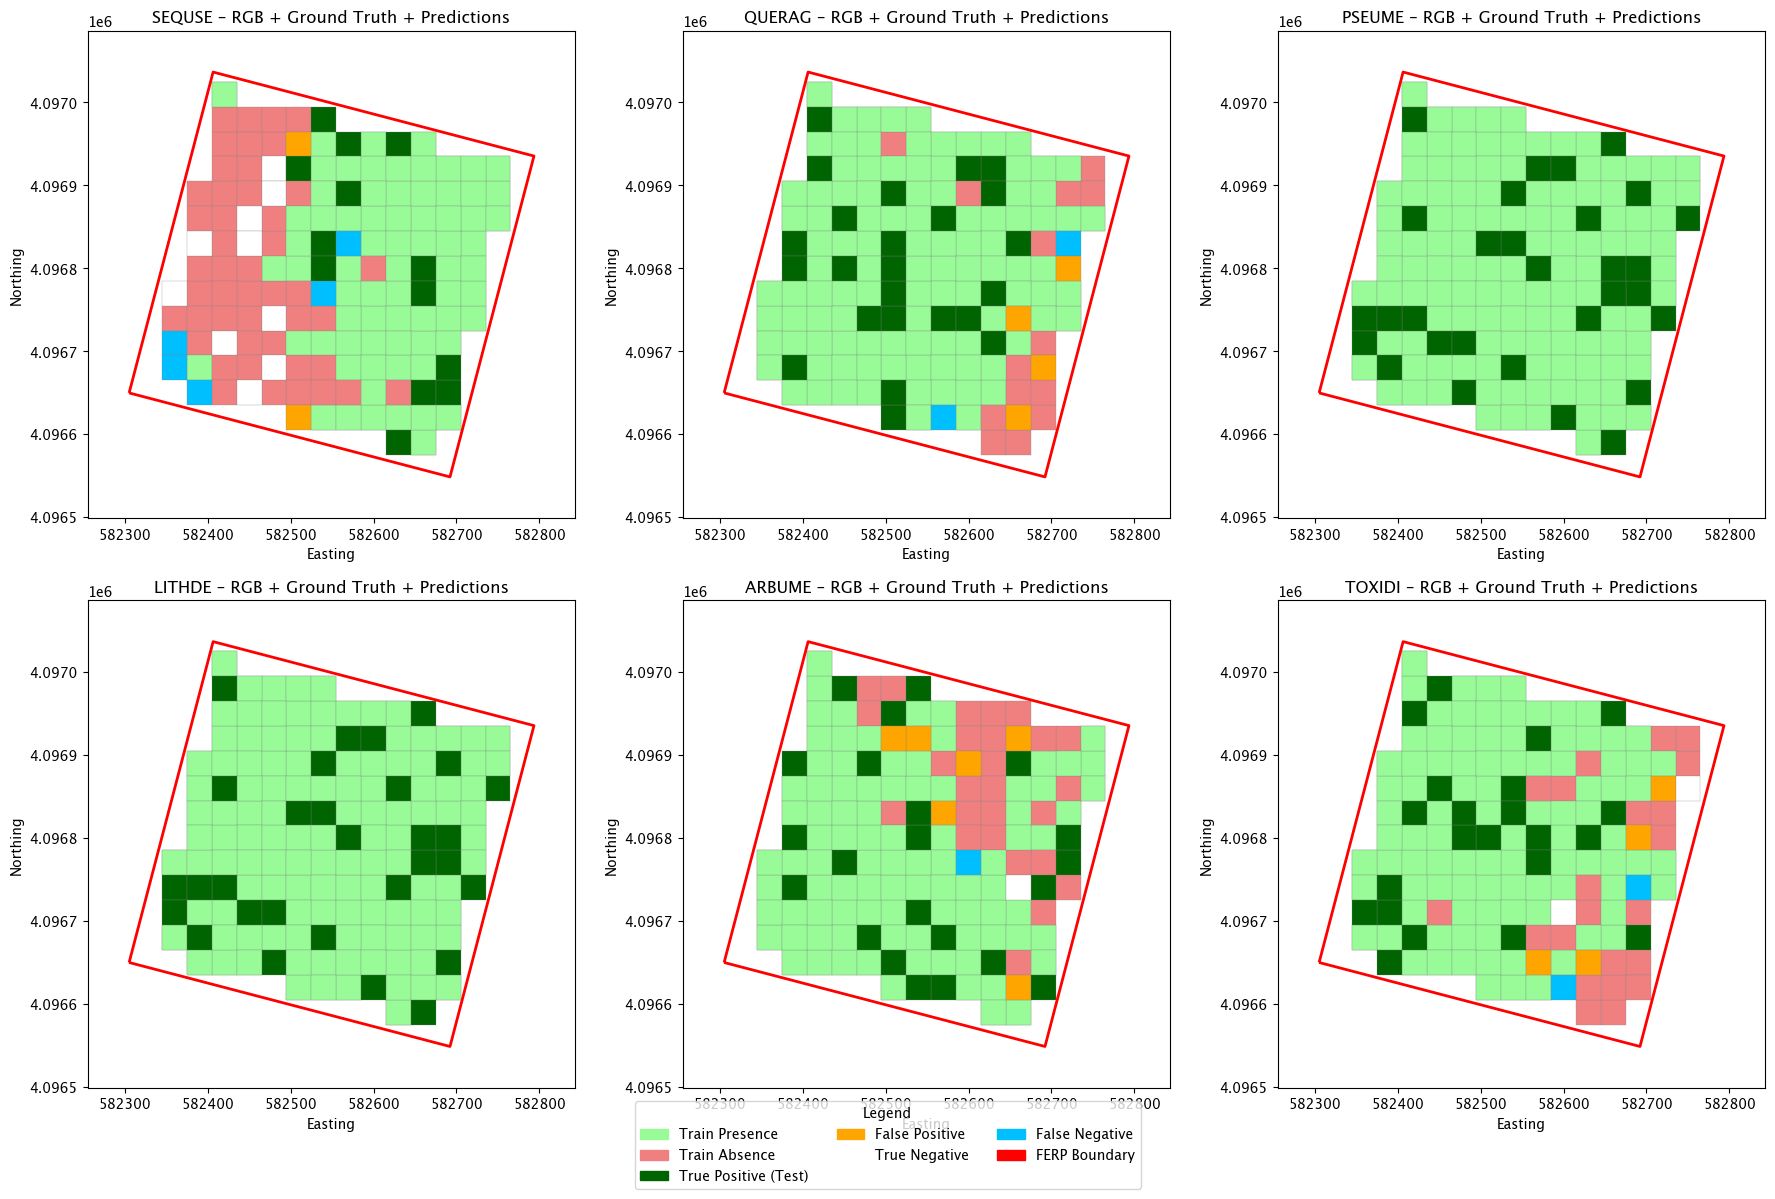

In [75]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import rasterio
from shapely.geometry import box, Point
from matplotlib.colors import Normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# -------------------------------
# Load FERP stem data
# -------------------------------
ferp_path = '../data/ferp/geoforest/doi_10_5061_dryad_6q573n64s__v20240129/FERP123merged_20231029.csv'
df = pd.read_csv(ferp_path)
df_geo = df.dropna(subset=["east_UTM", "north_UTM"]).copy()
gdf = gpd.GeoDataFrame(
    df_geo,
    geometry=gpd.points_from_xy(df_geo["east_UTM"], df_geo["north_UTM"]),
    crs="EPSG:32610"
)

# -------------------------------
# Load EnMAP hyperspectral cube
# -------------------------------
enmap_path = "../data/ferp/enmap/ENMAP01-____L2A-DT0000007897_20230215T193730Z_021_V010303_20230823T164547Z-SPECTRAL_IMAGE_COG.tiff"
with rasterio.open(enmap_path) as src:
    image = src.read()  # shape: (bands, height, width)
    transform = src.transform
    enmap_crs = src.crs
    width, height = src.width, src.height

# Stretch RGB for visualization
def stretch_rgb(rgb):
    vmin, vmax = np.percentile(rgb[rgb > -32768], [2, 98])
    return np.clip((rgb - vmin) / (vmax - vmin), 0, 1)

rgb_image = image[[44, 28, 9], :, :]
rgb_stretched = stretch_rgb(rgb_image)
rgb_plot = np.transpose(rgb_stretched, (1, 2, 0))  # H x W x 3
rgb_image_stretched = rgb_plot  # for compatibility

enmap_xmin = transform.c
enmap_xmax = transform.c + transform.a * width
enmap_ymax = transform.f
enmap_ymin = transform.f + transform.e * height
extent = [enmap_xmin, enmap_xmax, enmap_ymin, enmap_ymax]

# -------------------------------
# Reproject stem data and build grid
# -------------------------------
gdf_all = gdf.to_crs(enmap_crs)

# Build grid aligned with EnMAP pixels
pixel_width = transform.a
pixel_height = -transform.e
origin_x = transform.c
origin_y = transform.f

grid_cells = []
for row in range(height):
    for col in range(width):
        x0 = origin_x + col * pixel_width
        x1 = x0 + pixel_width
        y1 = origin_y - row * pixel_height
        y0 = y1 - pixel_height
        grid_cells.append(box(x0, y0, x1, y1))

grid = gpd.GeoDataFrame(geometry=grid_cells, crs=enmap_crs)

# Spatial join: link stems to grid pixels
joined = gpd.sjoin(gdf_all, grid, how="left", predicate="within").dropna(subset=["index_right"])
species_counts = (
    joined.groupby(["index_right", "code6"]).size().unstack(fill_value=0)
)
grid = grid.join(species_counts, how="left").fillna(0)

# -------------------------------
# Compute FERP boundary
# -------------------------------
df_q = df.dropna(subset=["quadrat"])
def parse_quadrat(q): return tuple(map(int, q.replace("E", "").split("_N")))
df_q["east_quadrat"], df_q["north_quadrat"] = zip(*df_q["quadrat"].map(parse_quadrat))

unique_quads = df_q[["east_quadrat", "north_quadrat"]].drop_duplicates()
quad_gdf = gpd.GeoDataFrame(
    unique_quads,
    geometry=[box(e, n, e + 20, n + 20) for e, n in zip(unique_quads["east_quadrat"], unique_quads["north_quadrat"])],
    crs="EPSG:32610"
)

ferp_boundary_utm = gpd.GeoDataFrame(
    geometry=[gdf_all.unary_union.minimum_rotated_rectangle],
    crs=gdf_all.crs
)
ferp_boundary_enmap = ferp_boundary_utm.to_crs(grid.crs)

# Filter EnMAP grid to pixels inside FERP
grid = grid[grid.geometry.within(ferp_boundary_enmap.geometry.iloc[0])]

# -------------------------------
# Train + Plot Results per Species
# -------------------------------
dom_code_l = ["SEQUSE", "QUERAG", "PSEUME", "LITHDE", "ARBUME", "TOXIDI"]
ncols, nrows = 3, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
axes = axes.flatten()

xmin, ymin, xmax, ymax = ferp_boundary_enmap.total_bounds
buffer = 50
xlim = (xmin - buffer, xmax + buffer)
ylim = (ymin - buffer, ymax + buffer)

for i, species_code in enumerate(dom_code_l):
    ax = axes[i]
    grid["y_true"] = (grid[species_code] > 0).astype(int)
    y = grid["y_true"].values

    centroids = grid.geometry.centroid
    xs, ys = centroids.x.values, centroids.y.values
    rows, cols = rasterio.transform.rowcol(transform, xs, ys)
    rows = np.clip(rows, 0, image.shape[1] - 1)
    cols = np.clip(cols, 0, image.shape[2] - 1)
    X = np.stack([image[band, rows, cols] for band in range(image.shape[0])], axis=1)

    valid_mask = np.isfinite(X).all(axis=1)
    X = X[valid_mask]
    y = y[valid_mask]
    grid_valid = grid[valid_mask].copy()

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, np.arange(len(y)), stratify=y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    grid_test = grid_valid.iloc[idx_test].copy()
    grid_train = grid_valid.iloc[idx_train].copy()
    grid_test["y_true"] = y_test
    grid_test["y_pred"] = y_pred

    grid_test["tp"] = (grid_test["y_true"] == 1) & (grid_test["y_pred"] == 1)
    grid_test["fp"] = (grid_test["y_true"] == 0) & (grid_test["y_pred"] == 1)
    grid_test["fn"] = (grid_test["y_true"] == 1) & (grid_test["y_pred"] == 0)

    # --- Draw TRAIN pixels (always known y, no predictions)
    for _, row in grid_train.iterrows():
        color = "palegreen" if row[species_code] > 0 else "lightcoral"
        minx, miny, maxx, maxy = row.geometry.bounds
        ax.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny,
                                facecolor=color, edgecolor="gray", linewidth=0.2, zorder=1))

    # --- Draw TEST pixels (predictions evaluated)
    for _, row in grid_test.iterrows():
        if row["y_true"] == 1 and row["y_pred"] == 1:
            color = "darkgreen"       # True Positive
        elif row["y_true"] == 0 and row["y_pred"] == 1:
            color = "orange"          # False Positive
        elif row["y_true"] == 1 and row["y_pred"] == 0:
            color = "deepskyblue"     # False Negative
        else:
            color = "white"           # True Negative

        minx, miny, maxx, maxy = row.geometry.bounds
        ax.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny,
                                facecolor=color, edgecolor="gray", linewidth=0.2, zorder=2))



    for _, row in grid_train[grid_train[species_code] > 0].iterrows():
        minx, miny, maxx, maxy = row.geometry.bounds
        ax.add_patch(plt.Rectangle((minx, miny), maxx - minx, maxy - miny,
                                   facecolor="palegreen", edgecolor="gray", linewidth=0.2, zorder=0))

    ferp_boundary_enmap.boundary.plot(ax=ax, color="red", linewidth=2, zorder=5)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"{species_code} – RGB + Ground Truth + Predictions", fontsize=12)
    ax.set_xlabel("Easting")
    ax.set_ylabel("Northing")

# Shared legend
legend_patches = [
    mpatches.Patch(color="palegreen", label="Train Presence"),
    mpatches.Patch(color="lightcoral", label="Train Absence"),
    mpatches.Patch(color="darkgreen", label="True Positive (Test)"),
    mpatches.Patch(color="orange", label="False Positive"),
    mpatches.Patch(color="white", label="True Negative"),
    mpatches.Patch(color="deepskyblue", label="False Negative"),
    mpatches.Patch(color="red", label="FERP Boundary"),
]


fig.legend(handles=legend_patches, title="Legend", loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.01))
plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.show()


In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

results = []

for i, species_code in enumerate(dom_code_l):
    # (Assumes all preprocessing + model training + prediction steps were done earlier per species)

    # Compute metrics from test set
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]) if len(np.unique(y_test)) > 1 else np.nan
    support_pos = sum(y_test)
    support_neg = len(y_test) - support_pos

    results.append({
        "Species": species_code,
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1 Score": round(f1, 2),
        "Accuracy": round(acc, 2),
        "ROC AUC": round(roc_auc, 2) if not np.isnan(roc_auc) else "NA",
        "Test Positives": support_pos,
        "Test Negatives": support_neg
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display table
import IPython.display as disp
disp.display(results_df)


,Species,Precision,Recall,F1 Score,Accuracy,ROC AUC,Test Positives,Test Negatives
0,SEQUSE,0.85,0.92,0.88,0.8,0.92,24,6
1,QUERAG,0.85,0.92,0.88,0.8,0.92,24,6
2,PSEUME,0.85,0.92,0.88,0.8,0.92,24,6
3,LITHDE,0.85,0.92,0.88,0.8,0.92,24,6
4,ARBUME,0.85,0.92,0.88,0.8,0.92,24,6
5,TOXIDI,0.85,0.92,0.88,0.8,0.92,24,6
